In [1]:
from sklearnex import patch_sklearn
patch_sklearn()
import pandas as pd
import nltk
import string,re
import joblib

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (ConfusionMatrixDisplay,classification_report,accuracy_score,
                            precision_score,roc_auc_score)
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline as pp

pd.set_option('display.max_colwidth', 400)
pd.set_option('display.max_rows', 1000) 

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
df_cleaned = pd.read_csv("./dataset/vax_tweets_sentiment_cleaned.csv")

In [3]:
df_cleaned.head()

,orig_text,sentiment,user_name,date,hashtags,cleaned_text
0,Same folks said daikon paste could treat a cytokine storm #PfizerBioNTech https://t.co/xeHhIMg1kF,neutral,Rachel Roh,2020-12-20,['PfizerBioNTech'],same folks daikon paste could treat cytokine storm
1,"While the world has been on the wrong side of history this year, hopefully, the biggest vaccination effort we've ev… https://t.co/dlCHrZjkhm",positive,Albert Fong,2020-12-13,NaN,while world wrong side history year hopefully biggest vaccination effort ev
2,#coronavirus #SputnikV #AstraZeneca #PfizerBioNTech #Moderna #Covid_19 Russian vaccine is created to last 2-4 years… https://t.co/ieYlCKBr8P,neutral,eli🇱🇹🇪🇺👌,2020-12-12,"['coronavirus', 'SputnikV', 'AstraZeneca', 'PfizerBioNTech', 'Moderna', 'Covid_19']",russian vaccine created last years
3,"Facts are immutable, Senator, even when you're not ethically sturdy enough to acknowledge them. (1) You were born i… https://t.co/jqgV18kch4",neutral,Charles Adler,2020-12-12,NaN,facts immutable senator even not ethically sturdy enough acknowledge were born
4,Explain to me again why we need a vaccine @BorisJohnson @MattHancock #whereareallthesickpeople #PfizerBioNTech… https://t.co/KxbSRoBEHq,neutral,Citizen News Channel,2020-12-12,"['whereareallthesickpeople', 'PfizerBioNTech']",explain again need vaccine


In [4]:
#Split dataset into training and test set

x = df_cleaned['cleaned_text']
y = df_cleaned['sentiment']

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

In [5]:
def create_grid_search(ml_algo):
    tfidf = TfidfVectorizer()
  
    param_grid = {'svc__C': [0.1,1, 10,100],
                 'tfidf__ngram_range':[(1,1),(1,2)],
                 'tfidf__max_features':[4000,11000,None]}
                        
    pipe = Pipeline(steps=[("tfidf", tfidf), ("svc", ml_algo)])
    
    search = GridSearchCV(pipe, param_grid, cv=10, scoring="balanced_accuracy", n_jobs=-1)
    return search

In [6]:
#Run gridsearchcv to find best parameter for tfidf and machine learning algorithm

svc = LinearSVC(random_state=1337,max_iter=10000)

model_grid_search = create_grid_search(svc)


model_grid_search.fit(X_train,y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('tfidf', TfidfVectorizer()),
                                       ('svc',
                                        LinearSVC(max_iter=10000,
                                                  random_state=1337))]),
             n_jobs=-1,
             param_grid={'svc__C': [0.1, 1, 10, 100],
                         'tfidf__max_features': [4000, 11000, None],
                         'tfidf__ngram_range': [(1, 1), (1, 2)]},
             scoring='balanced_accuracy')

In [7]:
print(model_grid_search.best_estimator_)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('svc', LinearSVC(C=10, max_iter=10000, random_state=1337))])


In [8]:
tfidf = TfidfVectorizer(ngram_range=(1,2))
tfidf.fit(X_train)

X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [9]:
#Undersampling functions

def undersampling(ml_algo):
    result = pd.DataFrame()
    no_of_sample = pd.DataFrame()
    
    for sampler,index_text in [(TomekLinks(sampling_strategy = ['neutral'], n_jobs=-1),'SVM+TomekLinks')]:
                   
        us_xtrain_tfidf, us_train_y = sampler.fit_resample(X_train_tfidf, y_train)
        ml_algo.fit(us_xtrain_tfidf,us_train_y)
        
        result = pd.concat([result,evaluate(ml_algo,index_text)])
    return result 

In [10]:
#Oversampling functions

def oversampling(ml_algo):
    result = pd.DataFrame()
    for sampler,index_text in [(SMOTE(sampling_strategy={'positive': 6000,'negative': 6000},random_state=777,
                                     n_jobs=-1), 'SVM+SMOTE')]:
        
        os_xtrain_tfidf, os_train_y = sampler.fit_resample(X_train_tfidf, y_train)
        ml_algo.fit(os_xtrain_tfidf,os_train_y)

        result = pd.concat([result,evaluate(ml_algo,index_text)])
    return result 

In [11]:
#Oversampling + Undersampling functions

def over_under_sampling(ml_algo):
    result = pd.DataFrame()
    
      
    for sampler_over,index_text_over in [(SMOTE(sampling_strategy={'positive': 6000,'negative': 6000},
                                               random_state=777, n_jobs=-1), 'SMOTE')]:
        for sampler_under,index_text_under in [(TomekLinks(sampling_strategy = ['neutral'], n_jobs=-1),
                                                'TomekLinks')]:
            
            over = sampler_over
            under = sampler_under
    
            steps = [('o', over), ('u', under), ('m', ml_algo)]
            pipeline = pp(steps=steps)
    
            pipeline.fit(X_train_tfidf, y_train)
            result = pd.concat([result,evaluate(ml_algo,"SVM+"+index_text_over+"+"+index_text_under)])
    return result   

In [12]:
#Classification performance evaluation

def evaluate(model,index_text):
    predict = model.predict(X_test_tfidf)
    
    class_report = classification_report(y_test,predict,output_dict=True)
    accuracy = class_report['accuracy']
    precision = class_report['weighted avg']['precision']
    recall = class_report['weighted avg']['recall']
    f1 = class_report['weighted avg']['f1-score']
    
    predict_proba = model._predict_proba_lr(X_test_tfidf)
    roc_auc = roc_auc_score(y_test, predict_proba, average="weighted", multi_class="ovr")
        
    print("\n"+index_text+"\n")
    print(classification_report(y_test,predict))
    
    print("\nROC AUC: " + str(roc_auc))
    
    print("\nConfusion Matrix:\n")
    ConfusionMatrixDisplay.from_predictions(y_test, predict)
    plt.show()
    
    return pd.DataFrame(
        data={"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1-Score": f1, 
              "ROC AUC": roc_auc},
        index=[index_text]
    )


SVM

              precision    recall  f1-score   support

    negative       0.67      0.56      0.61       839
     neutral       0.84      0.88      0.86      3334
    positive       0.79      0.76      0.77      1170

    accuracy                           0.80      5343
   macro avg       0.76      0.73      0.75      5343
weighted avg       0.80      0.80      0.80      5343


ROC AUC: 0.8857826333834614

Confusion Matrix:



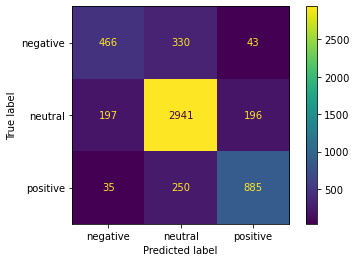

In [13]:
#SVM using original dateset

svc = LinearSVC(C=10, max_iter=10000, random_state=1337)
svc.fit(X_train_tfidf,y_train)

eval_result = evaluate(svc,"SVM")


SVM+Class Weight Balanced

              precision    recall  f1-score   support

    negative       0.67      0.57      0.61       839
     neutral       0.84      0.88      0.86      3334
    positive       0.78      0.76      0.77      1170

    accuracy                           0.80      5343
   macro avg       0.76      0.74      0.75      5343
weighted avg       0.80      0.80      0.80      5343


ROC AUC: 0.8861654125634272

Confusion Matrix:



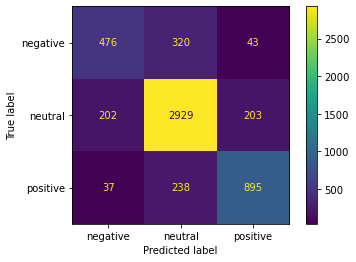

In [14]:
#SVM using class weight balanced parameter on original dataset

svc_weight = LinearSVC(C=10, max_iter=10000, class_weight='balanced',random_state=1337)
svc_weight.fit(X_train_tfidf,y_train)
eval_result = pd.concat([eval_result,evaluate(svc_weight,"SVM+Class Weight Balanced")])


SVM+TomekLinks

              precision    recall  f1-score   support

    negative       0.66      0.57      0.61       839
     neutral       0.84      0.87      0.86      3334
    positive       0.78      0.76      0.77      1170

    accuracy                           0.80      5343
   macro avg       0.76      0.73      0.74      5343
weighted avg       0.80      0.80      0.80      5343


ROC AUC: 0.8868388496137487

Confusion Matrix:



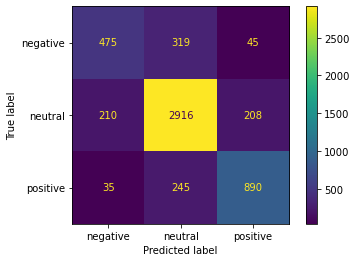

In [15]:
#SVM using undersampled dataset

svc = LinearSVC(C=10, max_iter=10000, random_state=1337)
eval_result = pd.concat([eval_result,undersampling(svc)])


SVM+SMOTE

              precision    recall  f1-score   support

    negative       0.66      0.56      0.61       839
     neutral       0.84      0.88      0.86      3334
    positive       0.79      0.76      0.77      1170

    accuracy                           0.80      5343
   macro avg       0.76      0.73      0.75      5343
weighted avg       0.80      0.80      0.80      5343


ROC AUC: 0.8852966039348693

Confusion Matrix:



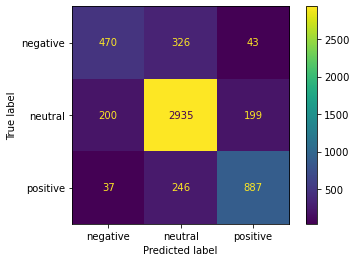

In [16]:
#SVM using oversampled dataset

eval_result = pd.concat([eval_result,oversampling(svc)])


SVM+SMOTE+TomekLinks

              precision    recall  f1-score   support

    negative       0.67      0.56      0.61       839
     neutral       0.84      0.88      0.86      3334
    positive       0.78      0.75      0.77      1170

    accuracy                           0.80      5343
   macro avg       0.76      0.73      0.75      5343
weighted avg       0.80      0.80      0.80      5343


ROC AUC: 0.8853779373899134

Confusion Matrix:



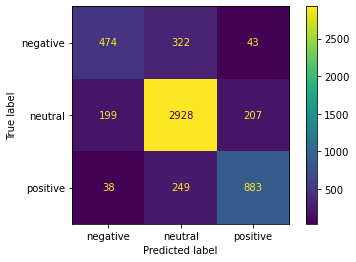

In [17]:
#SVM using oversampled & undersampled dataset

eval_result = pd.concat([eval_result,over_under_sampling(svc)])

In [18]:
#SVM performance comparison between original and resampled dataset

eval_result

,Accuracy,Precision,Recall,F1-Score,ROC AUC
SVM,0.803294,0.798457,0.803294,0.799601,0.885783
SVM+Class Weight Balanced,0.804791,0.800446,0.804791,0.801706,0.886165
SVM+TomekLinks,0.801235,0.796967,0.801235,0.798272,0.886839
SVM+SMOTE,0.803294,0.798649,0.803294,0.799874,0.885297
SVM+SMOTE+TomekLinks,0.801984,0.797510,0.801984,0.798732,0.885378


In [19]:
#Save the best model using joblib

svc = LinearSVC(C=10, max_iter=10000, class_weight='balanced',random_state=1337)

tfidf = TfidfVectorizer(ngram_range=(1,2))

pipe_model = Pipeline(steps=[("tfidf", tfidf), ("svc", svc)])

pipe_model.fit(X_train,y_train)

joblib.dump(pipe_model, './model/svm_model.joblib')

['./model/svm_model.joblib']